# Notebook evaluating metrics for particular node/edge configuration

In [1]:
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import imports as ip
import netconf as nc
import plotting as pl
import helper_functions as hf

In [2]:
## Define variables
# Label imports
groundTruth = "./data/beirutDamages.shp" # Damages shapefile
crs = 'epsg:4326' # Coordinate system to be used
cn = 'decision' # Column for classes
splitString = False # Only use first word in class column
confidence = [0, 1] # Confidence in a priori labels (other classes, specified class)

# Data imports
dataTypes = ['ifg',[0,1,2]]
ifgPreFile = "./data/beirutPrePreExplosionIfg.tif" # SNAP output 1
ifgPostFile = "./data/beirutPrePostExplosionIfg.tif" # SNAP output 2
ifgBoth = False # If false, only uses prePost rather than difference between two
crsIfg = 'epsg:4326'
hrPreFile = "data/highRes/20JUL31083035-S2AS-MEDIA-Beirut-JUL31-small.TIF" # High Res image Pre
hrPostFile = "data/highRes/20AUG05084637-S2AS-MEDIA-Beirut-AUG05-25km.TIF" # High resolution img Post
crsHr = 'epsg:32636'

# Map filtering of location
lat, lon, zoom = 33.893, 35.512, 14 # Map properties
stdTest = False # Use standard area for Beirut testing

# Class options
nClasses = False # Enforce number of classes (False -> # classes in labels)
classNames = False #['Undamaged','Damaged'] # Enforce names of classes (False -> cl0, cl1,...)
classAssign = False #[['GREEN','LAND'],['YELLOW','RED','TOTAL']] # Enforce class grouping (False -> Clustering is performed)
pca, pcaComps, meanCluster = False, 2, True # Clustering properties if used

# Edge creation
adjacent, geoNeighbours = False, 4 # geographical edges, n neighbours
phase, neighbours = True, [3] # Data value edges, n neighbours for each data type

In [3]:
## Import Labels and combine
labels = ip.shape_to_gdf(groundTruth, splitString, cn, crs=crs)

# Display map of assessments upon which to draw Polygon for analysis
m1 = pl.create_map(lat, lon, zoom)
m1 = pl.plot_assessments(labels, m1)
m1, testPoly = pl.draw_polygon(labels, m1, stdTest)
m1

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [4]:
## Import data
# High-Resolution Imagery import
hrPreGdf = ip.img_to_gdf(hrPreFile, testPoly, crs=crsHr)#,  columns=dataTypes[1])
hrPostGdf = ip.img_to_gdf(hrPostFile, testPoly, crs=crsHr)#,  columns=dataTypes[1])
hrGdf = hf.subtract_gdfs(hrPostGdf, hrPreGdf)

# # Interferometry
# ifg, poly = ip.image_to_df(ifgPostFile, dataTypes[0], testPoly) # Import interferogram to dataframe
# if ifgBoth: # If using both interferograms then subtract phase of second from first to get differecne
#     ifgPre, _ = ip.image_to_df(ifgPreFile, dataTypes[0], testPoly)
#     ifg = ifgPre-ifg
# ifgGdf = hf.df_to_gdf(ifg, [dataTypes[0]],crs=crsIfg,reIndex=True, invCoords=True)

# Merge into data
data = hrGdf.copy()

In [5]:
# Assign Label classes to data
defClasses, labelsUsed, dataUsed = len(labels[cn].unique()), labels.copy(), data.copy() # Default classes from labels
usedNames = labels[cn].unique() if nClasses==defClasses or nClasses is False else classNames
initial = hf.init_beliefs(dataUsed, classes=nClasses, columns=usedNames, crs=crs) # Initial class value for each data pixel

if not nClasses: nClasses = defClasses # If default classes used
elif nClasses > defClasses: raise NameError('Cannot assign more classes than in original data') # If invalid input
elif nClasses < defClasses: # Perform class grouping
    if not classAssign: # Perform clustering
        # Assign labels to each pixel
        allPixels = hf.create_nodes(initial, labelsUsed[['geometry',cn]][labelsUsed.within(poly)])
        # Run PCA if set to True
        X = hf.run_PCA(dataUsed[dataTypes[0]].values.transpose(), pcaComps).components_.transpose() if pca else dataUsed[dataTypes[0]]
        # Run clustering
        kmeans, clusterClasses, initLabels = hf.run_cluster(X[allPixels[cn].dropna().index].values.reshape(-1,1), allPixels[cn].dropna(), meanCluster, nClasses)
        print('Clustered classes:{} , original classes:{}'.format(clusterClasses, initLabels))
        # Create groups of classes
        classesUsed = []
        for j in range(nClasses): classesUsed.append([initLabels[i] for i, x in enumerate(list(clusterClasses)) if x==j])
    else: 
        classesUsed = classAssign
        #used = [i in flatten_list(classesUsed) for i in labelsUsed[cn]]
        initial = hf.init_beliefs(dataUsed, classes=nClasses, columns=usedNames, crs=crs)
    # Assign labels for each pixel after clustering
    labelsUsed[cn] = hf.group_classes(labelsUsed[cn], classesUsed)

In [6]:
# Split train/test set for located nodes
X_train, X_test, y_train, y_test = hf.train_test_split(labelsUsed, cn, hf.get_polygon(testPoly))

# Create nodes
nodes = hf.create_nodes(initial, X_train)

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, beliefColumns = initial.columns[-nClasses:], classNames=classNames, column = cn)

# Create edges
#values=dataTypes if phase else False
edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbors=geoNeighbours, values=[dataTypes[1]] , neighbours=neighbours)

In [7]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True,limit=1e-3)

Nodes: 43056, Edges: 129168
It	Loss	Label change

0	4.59184e-01		2955

1	1.03120e-01		1238

2	4.35774e-02		654

3	1.09344e-02		345

4	8.76096e-03		189

5	2.40675e-03		94

6	1.77129e-03		49

7	5.31401e-04		27

Time elapsed: 49.745981216430664 seconds


              precision    recall  f1-score   support

       GREEN       0.64      0.89      0.74      2777
      YELLOW       0.15      0.04      0.06      1446

    accuracy                           0.60      4223
   macro avg       0.39      0.46      0.40      4223
weighted avg       0.47      0.60      0.51      4223



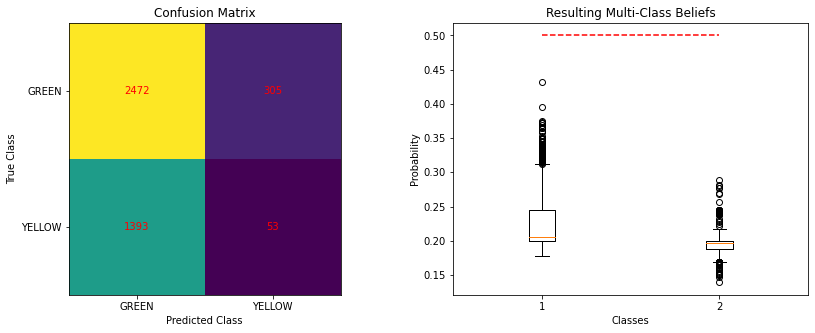

In [8]:
# Evaluation Metrics
# Get y_true vs y_pred for test set
y_true, y_pred = hf.get_labels(initial, X_test, beliefs, column=cn)

# Classification metrics
yp_clf, classes = hf.class_metrics(y_true, y_pred, classes=usedNames, orig=classNames)

fig, axs = pl.create_subplots(1,2, figsize=[14,5])
# Confusion matrix
axs = pl.confusion_matrix(axs, y_true, yp_clf, classes)
  
# Cross entropy / Confidence metrics
if nClasses == 2: axs = pl.cross_entropy_metrics(axs, y_true, y_pred[:,1].reshape(-1,1), classes)
else: axs[1] = pl.cross_entropy_multiclass(axs[1], y_true, y_pred)

pl.show_plot()

In [23]:
# Save figure
pl.save_plot(fig, 'results/Beirut_extraData_adj{}{}_hr{}{}_cl{}_std{}'.format(str(adjacent),str(geoNeighbours),str(phase),str(neighbours),str(nClasses),str(stdTest)))

KeyError: 'RED'

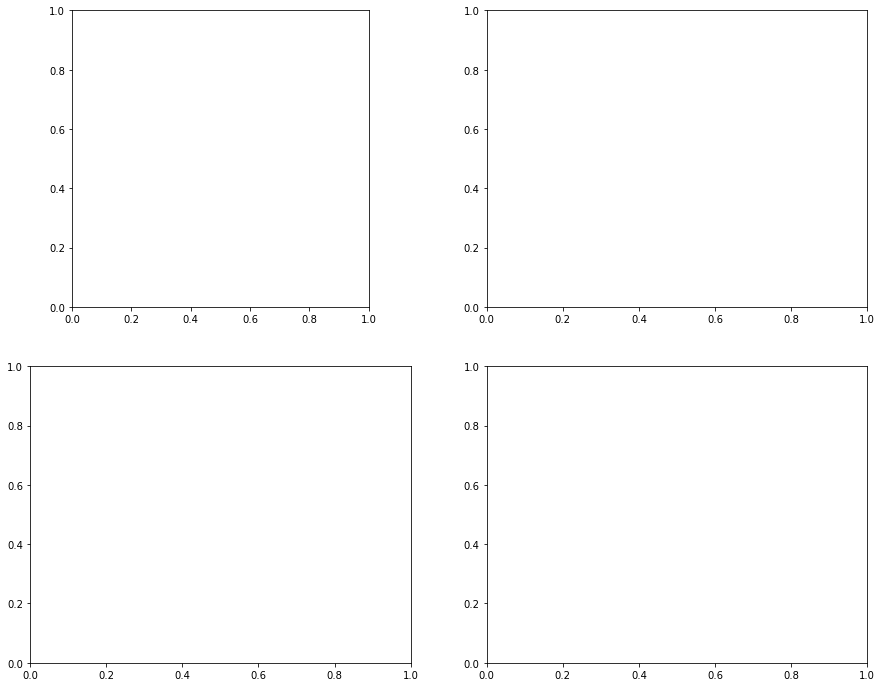

In [76]:
# Visualise spatial results
fig, axs = pl.create_subplots(2,2,figsize=[15,12])

prePlot = pl.belief_plot(nodes, axs[0,0], 'RED', normalise=False)
postPlot = pl.belief_plot(nodes, axs[0,1], beliefs, normalise=True)
assessPlt = joint.loc[joint.within(poly)].plot(ax=axs[1,0], column='decision',cmap='RdYlGn_r')
ifgPlot = (pl.cropped_ifg(ifgPreFile,testPoly)-pl.cropped_ifg(ifgPostFile,testPoly)).plot(ax=axs[1,1])
prePlot.set_title('A priori damage likelihood'), postPlot.set_title('Updated damage likelihood'), assessPlt.set_title('Damage Assessments')

pl.show_plot()